# COGS 108 - EDA Checkpoint

# Names

- Naomi Chin
- Leo Friedman
- Jake Heinlein
- Dante Tanjuatco
- Nathan Tripp

<a id='research_question'></a>
# Research Question

*Is the combination of an mlb free agents age and batting performance, measured by relevant batting statistics (Batting Average, On Base Percentage, Slugging Average, etc.) indicative of their yearly salary, and if so, can we predict a player's future salary based on these factors?*

# Setup

In [228]:
# import packages and setup visuals
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
import statistics

# Data Cleaning

### Contracts

Concatenate all contract csv files from years 1991-2022 as a dataframe named "contracts"

In [229]:
# merge all contract files in contracts directory as one dataframe
directory = 'data/contracts/'
filepaths = [directory + filename for filename in os.listdir(directory)]
contracts = pd.concat([pd.read_csv(filepath) for filepath in filepaths])
contracts_original = contracts
print('contracts shape: ', contracts.shape)
print('contracts columns: ', list(contracts.columns))

contracts shape:  (4996, 18)
contracts columns:  ['Player', "Pos'n", 'Age', 'Qual    Offer', 'Old    Club', 'New Club', 'Years', 'Guarantee', 'Term', 'Option', 'Opt Out', 'AAV', 'Player Agent', 'Club Owner', 'Baseball Ops      head / club GM', 'Details', 'Age 7/1/21', 'Age 7/1/22']


Combine the three columns, 'Age', 'Age 7/1/21', and 'Age 7/1/22', into one 'Age' column by taking the non-null value from each set of columns (if it exists). There are 18 columns per contract observation. Drop all columns that are irrelevant to our project. Now that the dataframe only contains relevant variables, drop all observations with NaN values. 

In [230]:
# set 'Age' column to value in 'Age  7/1/21' column or 'Age 7/1/22' column if NaN
contracts['Age'] = contracts['Age'].add(contracts['Age 7/1/21'], fill_value=0)
contracts['Age'] = contracts['Age'].add(contracts['Age 7/1/22'], fill_value=0)

# drop unecessary columns
contracts = contracts[['Player','Pos\'n', 'Age', 'Term', 'AAV']]

# drop players with NaN values
contracts = contracts.dropna(axis=0)

Our project is looking at how batting performance affects salary. Pitcher's salaries, however, are not indicative of their batting performance. Drop all pitchers from the "contract" dataframe.

In [231]:
# drop players that are pitchers
contracts = contracts[contracts["Pos'n"].str.contains("hp") == False]

# drop position column (no longer needed)
contracts = contracts.drop('Pos\'n',axis=1)

display(contracts.head())

,Player,Age,Term,AAV
0,"Strawberry, Darryl",29.0,1991-96,"$4,050,000"
2,"McGee, Willie",32.0,1991-94,"$3,250,000"
5,"Coleman, Vince",29.0,1991-94,"$2,987,500"
8,"Pendleton, Terry",30.0,1991-94,"$2,550,000"
11,"Bell, George",31.0,1991-93,"$3,266,666"


Next, standardize our variables so we can plot and compare them with values from other datasets. 

In [232]:
# convert a players yearly salary (AAV) from a string to an int
def salary_to_int(str_in):
    return int(str_in.replace('$','').replace(',',''))

# convert the term of a player's contract (Term) to the year they were offered it
def term_to_year(str_in):
    return int(str(str_in).split('-')[0])

# standardize player names
def standardize_name(str_in):
    if ',' in str_in:
        name_list = str(str_in).split(',')
        str_in = name_list[1].strip() + " " + name_list[0].strip()
    str_in = str_in.replace('Jr.','')
    str_in = str_in.replace('Sr.','')
    str_in = str_in.replace('.','')
    str_in = str_in.replace('é','e')
    str_in = str_in.replace('á','a')
    return str_in.replace(' ', '')

# round all ages
def standardize_age(age):
    return round(float(age), 0)

In [233]:
# standardize name, age, salary, and term variables
contracts['Player'] = contracts['Player'].apply(standardize_name)
contracts['Age'] = contracts['Age'].apply(standardize_age)
contracts['AAV'] = contracts['AAV'].apply(salary_to_int)
contracts['Term'] = contracts['Term'].apply(term_to_year)
display(contracts.head())

,Player,Age,Term,AAV
0,DarrylStrawberry,29.0,1991,4050000
2,WillieMcGee,32.0,1991,3250000
5,VinceColeman,29.0,1991,2987500
8,TerryPendleton,30.0,1991,2550000
11,GeorgeBell,31.0,1991,3266666


Rename contract columns for consistency. Drop all observations with contract values of $1. 

In [234]:
# rename columns for consistency
contracts.columns = ['playerName','playerAge','year','yearSalary']

# drop contracts that had a yearSalary of $1
contracts = contracts[contracts['yearSalary'] > 1]

display(contracts.head())

,playerName,playerAge,year,yearSalary
0,DarrylStrawberry,29.0,1991,4050000
2,WillieMcGee,32.0,1991,3250000
5,VinceColeman,29.0,1991,2987500
8,TerryPendleton,30.0,1991,2550000
11,GeorgeBell,31.0,1991,3266666


### Batting

Read Batting.csv file as a dataframe named "batting". Read People.csv file (a lookup table that has player names, age, etc.) as a dataframe named "people".

In [235]:
# read people and batting files as dataframes
people = pd.read_csv('data/batting/People.csv')
batting = pd.read_csv('data/batting/Batting.csv')
batting_original = batting
print('people shape: ', people.shape)
print('batting shape: ', batting.shape)

people shape:  (20370, 24)
batting shape:  (110495, 22)


Drop irrelevant columns from batting

In [236]:
batting = batting[['playerID', 'yearID', 'AB', 'H', '2B', '3B', 'HR', 'BB','HBP','SF']]
display(batting.head())

,playerID,yearID,AB,H,2B,3B,HR,BB,HBP,SF
0,abercda01,1871,4,0,0,0,0,0,NaN,NaN
1,addybo01,1871,118,32,6,0,0,4,NaN,NaN
2,allisar01,1871,137,40,4,5,0,2,NaN,NaN
3,allisdo01,1871,133,44,10,2,2,0,NaN,NaN
4,ansonca01,1871,120,39,11,3,0,2,NaN,NaN


After running the cell below you can see that some players have two sets of batting stats from the same year. This is because they were on two different teams during one year. Combine these stats such that every player only has one set of stats per year. 

*NOTE: This takes quite a bit of time to run.*

In [237]:
# example of player with ID 'abramca01' who has two sets of batting stats for the years 1952 and 1954
display(batting[batting['playerID'] == 'abramca01']['yearID'].value_counts())

1952    2
1954    2
1949    1
1950    1
1951    1
1953    1
1955    1
1956    1
Name: yearID, dtype: int64

In [238]:
# summing batting stats from the same year
batting = batting.groupby(['playerID', 'yearID']).agg(lambda x: x.sum(min_count=1))

# reset index
batting = batting.reset_index()

display(batting[batting['playerID'] == 'abramca01']['yearID'].value_counts())

1949    1
1950    1
1951    1
1952    1
1953    1
1954    1
1955    1
1956    1
Name: yearID, dtype: int64

Now that the dataframe only contains relevant variables, drop all observations with NaN values. Also drop observations with Zero "At Bats". A player can only be judged by their batting ability if they have batted at least once.

In [239]:
# drop observations with NaN values
batting = batting.dropna(axis=0)

# drop observations with 0 At Bats
batting = batting[batting['AB'] > 0]

This batting dataframe only contains the raw batting numbers per player in a given season (number of hits, strikes, homeruns, etc.). For our analysis, we want averaged data. Add columns for "Batting Average" (AVG), "On Base Percentage" (OBP), "Slugging Average" (SLG), and "On Base Plus Slugging Average" (OBS).

In [240]:
# calculate batting average
def calc_avg(h, ab):
    return h / ab
  
# calculate on base percentage
def calc_obp(h, bb, hbp, ab, sf):
    return (h + bb + hbp) / (ab + bb + sf + hbp)
    
# calculate total bases
def calc_tb(h, two_b, three_b, hr):
    singles = h - two_b - three_b - hr
    return singles + two_b * 2 + three_b * 3 + hr * 4

# calculate slugging average
def calc_slg(tb, ab):
    return tb / ab

# calculate on base plus slugging average
def calc_obs(obp, slg):
    return obp + slg

In [241]:
# create Batting Average column in batting dataframe
avg = calc_avg(h=batting['H'], ab=batting['AB'])
batting['AVG'] = round(avg, 3)

# create On Base Percentage average column in batting dataframe
obp = calc_obp(h=batting['H'], bb=batting['BB'], hbp=batting['HBP'], ab=batting['AB'], sf=batting['SF'])
batting['OBP'] = round(obp, 3)

# create Slugging average column in batting dataframe
tb = calc_tb(h=batting['H'], two_b=batting['2B'], three_b=batting['3B'], hr=batting['HR'])
slg = calc_slg(tb, batting['AB'])
batting['SLG'] = round(slg, 3)

# create On Base Plus Slugging column in batting dataframe
obs = calc_obs(obp, slg)
batting['OBS'] = round(obs, 3)

display(batting.head())

,playerID,yearID,AB,H,2B,3B,HR,BB,HBP,SF,AVG,OBP,SLG,OBS
1,aardsda01,2006,2,0,0,0,0,0,0.0,0.0,0.000,0.000,0.000,0.000
3,aardsda01,2008,1,0,0,0,0,0,0.0,0.0,0.000,0.000,0.000,0.000
8,aardsda01,2015,1,0,0,0,0,0,0.0,0.0,0.000,0.000,0.000,0.000
9,aaronha01,1954,468,131,27,6,13,28,3.0,4.0,0.280,0.322,0.447,0.769
10,aaronha01,1955,602,189,37,9,27,49,3.0,4.0,0.314,0.366,0.540,0.906


Now that our dataframe has these averages, drop all unecessary columns. Additionally, rename columns for consistency. 

In [242]:
# drop irrelevant columns
batting = batting[['playerID', 'yearID','AB', 'AVG', 'OBP','SLG','OBS']]

# rename columns for consitency
batting.columns = ['playerID', 'year', 'AB', 'AVG', 'OBP', 'SLG','OBS']

Eventually, we will be comparing data in the "contracts" dataframe to the "batting" dataframe. To do this, each observation in the dataframes needs to have some variable that is shared across both dataframes. In this case, use player names as the shared variable for lookups. 

The "batting" dataframe does not have player names, only player IDs. Use data from the "people" dataframe to add a playerName column to the "batting" dataframe. Standardize this playerName column.

In [243]:
# add name column to people that combines players first and last name
people['name'] = people['nameFirst'] + ' ' + people['nameLast']

# drop irrelevant columns
people = people[['playerID','name']]

# merge batting and people to add name column to batting dataframe
batting = batting.merge(people, how='left', on='playerID')

# rename and reorder  batting columns for consistency 
batting = batting.rename({'name':'playerName'}, axis=1)
batting = batting[['playerID','playerName','year','AB', 'AVG', 'OBP', 'SLG','OBS']]

# standardize playerName column
batting['playerName'] = batting['playerName'].apply(standardize_name)
batting.head()

,playerID,playerName,year,AB,AVG,OBP,SLG,OBS
0,aardsda01,DavidAardsma,2006,2,0.000,0.000,0.000,0.000
1,aardsda01,DavidAardsma,2008,1,0.000,0.000,0.000,0.000
2,aardsda01,DavidAardsma,2015,1,0.000,0.000,0.000,0.000
3,aaronha01,HankAaron,1954,468,0.280,0.322,0.447,0.769
4,aaronha01,HankAaron,1955,602,0.314,0.366,0.540,0.906


Our "contract" dataframe currently only contains contracts of free agent batters from the years 1991-2022. Our "batting" dataframe contains data on all players from 1871-2022. Drop all players from "batting" dataframe who do not appear in the "contracts" dataframe. 

*NOTE: the two original datasets occasionally used different naming conventions that could not be rectified through standardization. Because of this, "batting" ends up missing 22 names from "contracts".*

In [244]:
# remove players from batting who are not in contracts
batting = batting[batting['playerName'].isin(list(contracts['playerName'].unique()))]

# NOTE: 22 names in contracts missing from batting; Caused by naming disparities in databases;
missing_from_batting  = len(contracts['playerName'].unique()) - len(batting['playerName'].unique())
print('number of missing names from batting: ', missing_from_batting)

number of missing names from batting:  22


One final issue with our data is that a few players in the dataframes have the same name. These players should not be treated as the same player and may cause issues down the line. Remove all players with the same name from the dataframes.

In [245]:
# all names associated with a unique playerID
names = pd.Series([group[1]['playerName'].reset_index(drop=True)[0] for group in batting.groupby('playerID')])
name_counts = names.value_counts();

# list of players with the same name 
repeated_names = list(name_counts[name_counts > 1].index)

# remove batters and contracts with repeated names name
batting = batting[~batting['playerName'].isin(repeated_names)]
contracts = contracts[~contracts['playerName'].isin(repeated_names)]

The data cleaning is done! This is a breakdown of how the dataframes changed throughout the process.

In [246]:
# results of cleaning: 
print('original contracts dataframe: ')
print('\tshape: ', contracts_original.shape)
print('\tunique players: ', len(list(contracts_original['Player'].unique())))

print('new contracts dataframe: ')
print('\tshape: ', contracts.shape)
print('\tunique players: ', len(list(contracts['playerName'].unique())),'\n')

print('original batting dataframe: ')
print('\tshape: ', batting_original.shape)
print('\tunique players: ', len(list(batting_original['playerID'].unique())))

print('new batting dataframe: ')
print('\tshape: ', batting.shape)
print('\tunique players: ', len(list(batting['playerName'].unique())))

original contracts dataframe: 
	shape:  (4996, 18)
	unique players:  2050
new contracts dataframe: 
	shape:  (1421, 4)
	unique players:  753 

original batting dataframe: 
	shape:  (110495, 22)
	unique players:  20166
new batting dataframe: 
	shape:  (9423, 8)
	unique players:  731


# Data Analysis & Results (EDA)

Our first step in data analysis is to see whether the factors we're looking at (Age, AVG, OBP, etc.) are actually correlated with player salary. This involves looking up player statistics in the "batting" dataframe. To make this process easier we will make a DataFrameGroupBy named "batting_grouped" so that we can look up specific player stats during specific years.

In [213]:
batting_grouped = batting.groupby(['playerName','year'])

To plot factors against salary we need some functions that can return plottable data. The two functions below are used to return a list of tuples in the form (stat, salary). These tuples can be plotted later to look for relationships.

In [248]:
# get a player's statistics
# player (str): the name of the player
# year (float): the year of the statistics 
# return: a one row dataframe of the batting statistics 
def getBattingStats(player: str, year: float):
    try:
        return batting_grouped.get_group((player, year))
    except: 
        return None

# gets data for plotting a batting stat against a yearly salary.  
# stat (str) : the stat to plot against salary
# AB_limit (int) : drops any stat with less at bats than this
# years_back (int) : how many previous years of statistics to average.
# return: a list of tuples (stat, salary)
def getPlotableData(stat: str, AB_limit: int, years_back: int):
    data = []
    for index, contract in contracts.iterrows():
        if contract['playerName'] in list(batting['playerName']):
            year_salary = contract['yearSalary']
            average = 0
            for i in range(years_back):
                stats = getBattingStats(contract['playerName'], contract['year']-(i+1))
                if stats is not None and float(stats['AB']) > AB_limit:
                    average += float(stats[stat])
                else: 
                    average = -1
                    break
            if average != -1:
                data.append((float(average/years_back), year_salary))
    return data

<AxesSubplot: xlabel='AVG_3', ylabel='year salary'>

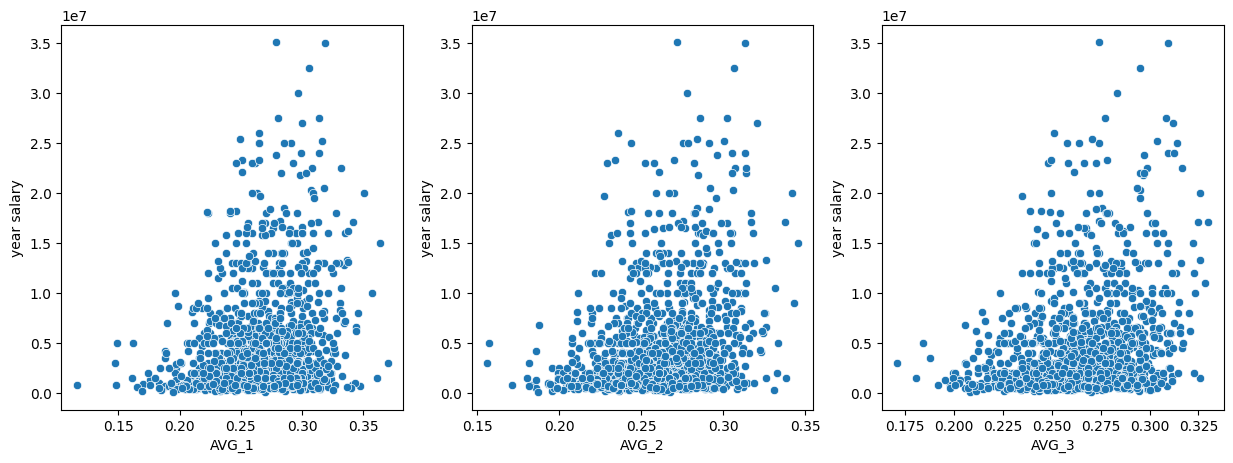

In [215]:
data_1 = pd.DataFrame(data= getPlotableData('AVG', 50, 1), columns = ['AVG_1', 'year salary']) 
data_2 = pd.DataFrame(data= getPlotableData('AVG', 50, 2), columns = ['AVG_2', 'year salary']) 
data_3 = pd.DataFrame(data= getPlotableData('AVG', 50, 3), columns = ['AVG_3', 'year salary']) 
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.scatterplot(data=data_1, x='AVG_1', y='year salary', ax=ax1)
sns.scatterplot(data=data_2, x='AVG_2', y='year salary', ax=ax2)
sns.scatterplot(data=data_3, x='AVG_3', y='year salary', ax=ax3)

Create three scatterplots of plotting on base percentage against yearly salary. The scatter plots ignore statistics with at bats under 50 and look 1, 2, and 3 years back respectively. There appears to be a positive relationship between OBP and salary.

<AxesSubplot: xlabel='OBP_3', ylabel='year salary'>

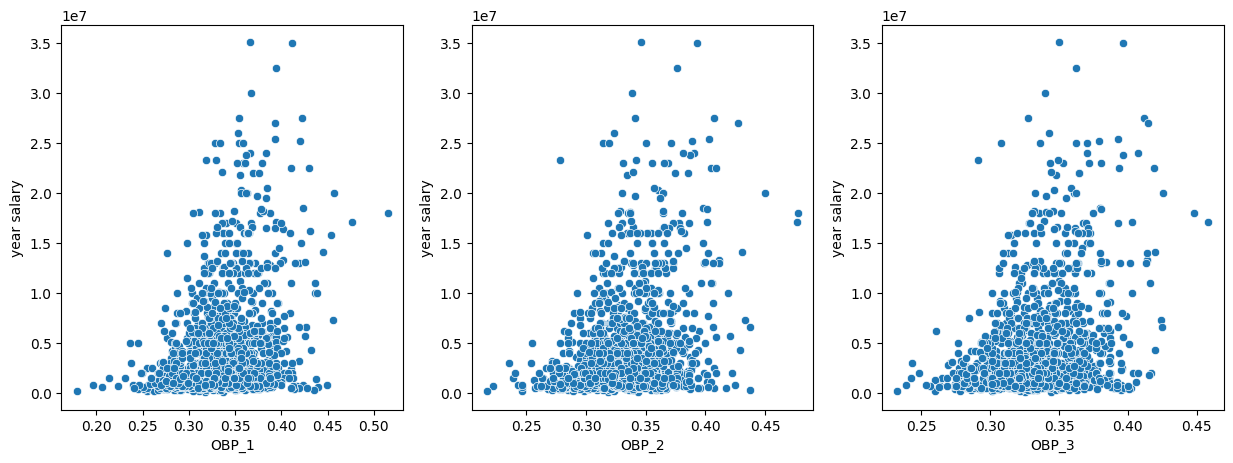

In [251]:
data_1 = pd.DataFrame(data= getPlotableData('OBP', 50, 1), columns = ['OBP_1', 'year salary']) 
data_2 = pd.DataFrame(data= getPlotableData('OBP', 50, 2), columns = ['OBP_2', 'year salary']) 
data_3 = pd.DataFrame(data= getPlotableData('OBP', 50, 3), columns = ['OBP_3', 'year salary']) 
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.scatterplot(data=data_1, x='OBP_1', y='year salary', ax=ax1)
sns.scatterplot(data=data_2, x='OBP_2', y='year salary', ax=ax2)
sns.scatterplot(data=data_3, x='OBP_3', y='year salary', ax=ax3)

<AxesSubplot: xlabel='SLG_3', ylabel='year salary'>

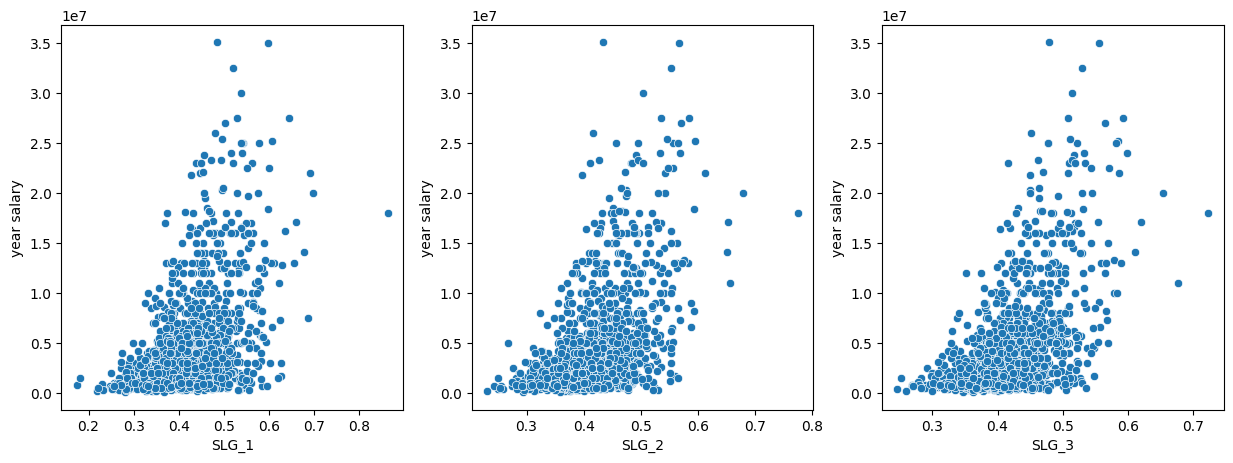

In [219]:
data_1 = pd.DataFrame(data= getPlotableData('SLG', 50, 1), columns = ['SLG_1', 'year salary']) 
data_2 = pd.DataFrame(data= getPlotableData('SLG', 50, 2), columns = ['SLG_2', 'year salary']) 
data_3 = pd.DataFrame(data= getPlotableData('SLG', 50, 3), columns = ['SLG_3', 'year salary']) 
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.scatterplot(data=data_1, x='SLG_1', y='year salary', ax=ax1)
sns.scatterplot(data=data_2, x='SLG_2', y='year salary', ax=ax2)
sns.scatterplot(data=data_3, x='SLG_3', y='year salary', ax=ax3)

<AxesSubplot: xlabel='OBS_3', ylabel='year salary'>

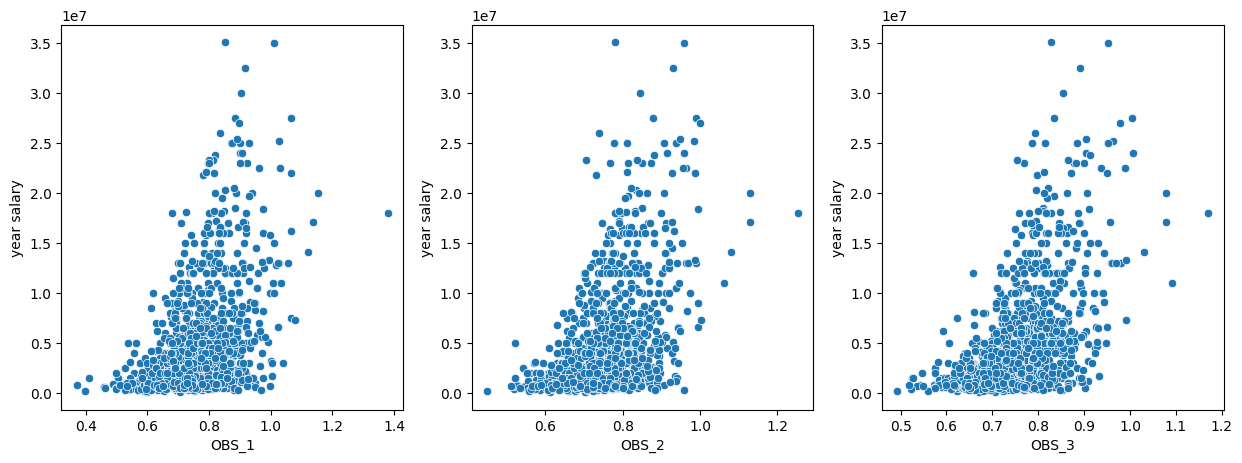

In [220]:
data_1 = pd.DataFrame(data= getPlotableData('OBS', 50, 1), columns = ['OBS_1', 'year salary']) 
data_2 = pd.DataFrame(data= getPlotableData('OBS', 50, 2), columns = ['OBS_2', 'year salary']) 
data_3 = pd.DataFrame(data= getPlotableData('OBS', 50, 3), columns = ['OBS_3', 'year salary']) 
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.scatterplot(data=data_1, x='OBS_1', y='year salary', ax=ax1)
sns.scatterplot(data=data_2, x='OBS_2', y='year salary', ax=ax2)
sns.scatterplot(data=data_3, x='OBS_3', y='year salary', ax=ax3)

Yearly salary predictions will depend on the year; factors including inflation and viewership are expected to alter MLB salaries from year to year. First, we will compare the MLB free agent contracts between 1991 and 2022.

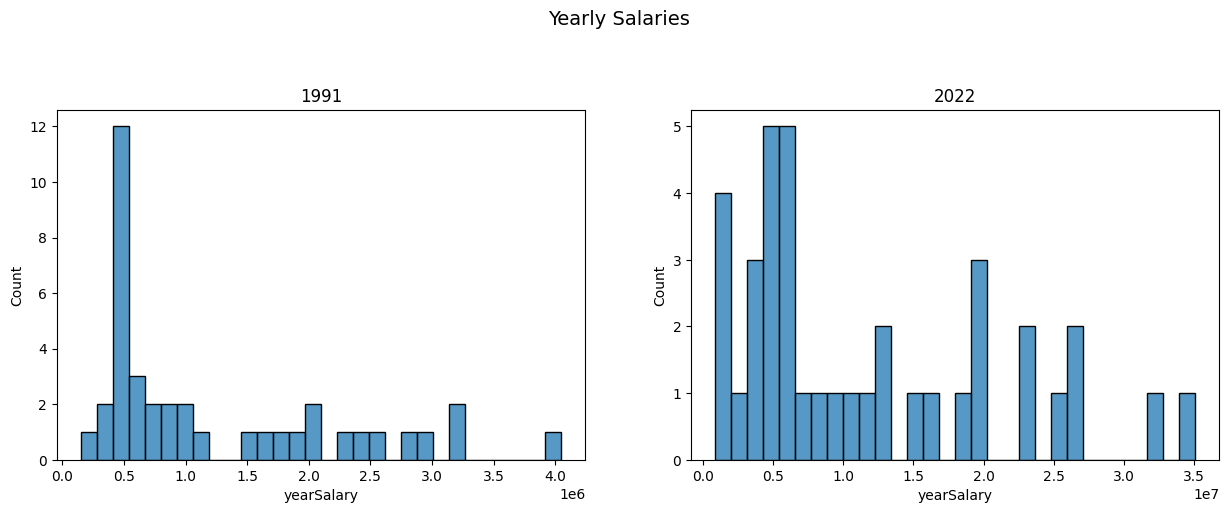

In [252]:
# compare yearly salaries between 1991 and 2022
fig = plt.figure(figsize=(15, 10))
plt.suptitle("Yearly Salaries", fontsize=14)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.title.set_text('1991')
ax2.title.set_text('2022')
sns.histplot(data = contracts[contracts['year'] == 1991], x = 'yearSalary', bins = 30, ax = ax1)
sns.histplot(data = contracts[contracts['year'] == 2022], x = 'yearSalary', bins = 30, ax = ax2)
plt.show()

As expected, the average yearly salary jumped a significant amount from 1991 to 2022. The highest contract from 1991 is around \\$4,000,000 compared to the highest contract from 2022 being close to \\$35,000,000. 

We will now look at the average salary from each year of data that we have obtained (1991-2022).

C:\Users\dantn\AppData\Local\Temp\ipykernel_17508\1820882526.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_years['avg salary'][i] = statistics.mean(contracts[contracts['year'] == salary_years['year'][i]]['yearSalary'])


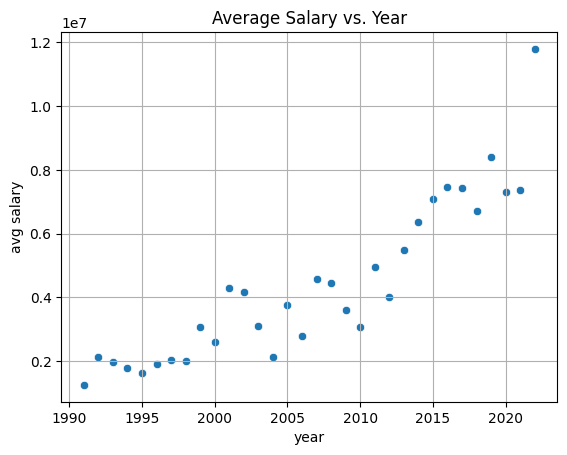

In [253]:
# compare average salaries over the years

salary_years = contracts['year'].value_counts().rename_axis('year').reset_index(name='counts')
salary_years['avg salary'] = ''
for i in range(len(salary_years)):
    salary_years['avg salary'][i] = statistics.mean(contracts[contracts['year'] == salary_years['year'][i]]['yearSalary'])
salary_years = salary_years.sort_values(by=['year']).reset_index(drop = True)
sns.scatterplot(data=salary_years, x='year', y='avg salary').set_title('Average Salary vs. Year')
plt.grid()
plt.show()
# try to fit the data (linear/exponential/etc)

The average salary has a general upward trend as the year increases. From these results, it is important to take into account the year when predicting salaries. 

In order to predict what information and stats are important for predicting salaries, we will take a look at the stats of the highest paid player from each year. Since we want to use previous performace to predict future salaries, we will first look at only the year prior to each contract. It will be helpful to get a better idea of what stats to expect given high salaries. 

In [254]:
# look at the previous year stats for the highest contract from each year

# find the maximum salary from each year
salary_years['max salary'] = ''
for i in range(len(salary_years)):
    salary_years['max salary'][i] = ((contracts[contracts['year'] == salary_years['year'][i]]['yearSalary'])  
    [(contracts[contracts['year'] == salary_years['year'][i]]['yearSalary']).idxmax()])


# find players with max salary
max_player = (contracts[contracts['year']==1991][contracts[contracts['year']==1991]['yearSalary'] ==
 int(salary_years[salary_years['year']==1991]['max salary'])])

for i in range(len(salary_years)-1):
    max_player=max_player.append(contracts[contracts['year']==salary_years['year'][i+1]][contracts[contracts['year']==
    salary_years['year'][i+1]]['yearSalary'] == int(salary_years[salary_years['year']==salary_years['year'][i+1]]['max salary'])])
max_player = max_player.reset_index(drop = True)

# find the previous year stats for each max salary player
max_player['previous AVG'] = ''
max_player['previous AVG'][0] = np.nan
max_player['previous OBP'] = ''
max_player['previous OBP'][0] = np.nan
max_player['previous SLG'] = ''
max_player['previous SLG'][0] = np.nan
max_player['previous OBS'] = ''
max_player['previous OBS'][0] = np.nan
for i in range(len(max_player)-1):
    max_player['previous AVG'][i+1] = (float(batting[batting['year'] == max_player['year'][i]]
    [batting[batting['year'] == max_player['year'][i]]['playerName'] == max_player['playerName'][i]]['AVG']))
for i in range(len(max_player)-1):
    max_player['previous OBP'][i+1] = (float(batting[batting['year'] == max_player['year'][i]]
    [batting[batting['year'] == max_player['year'][i]]['playerName'] == max_player['playerName'][i]]['OBP']))
for i in range(len(max_player)-1):
    max_player['previous SLG'][i+1] = (float(batting[batting['year'] == max_player['year'][i]]
    [batting[batting['year'] == max_player['year'][i]]['playerName'] == max_player['playerName'][i]]['SLG']))
for i in range(len(max_player)-1):
    max_player['previous OBS'][i+1] = (float(batting[batting['year'] == max_player['year'][i]]
    [batting[batting['year'] == max_player['year'][i]]['playerName'] == max_player['playerName'][i]]['OBS']))


# find the minimum salary from each year
salary_years['min salary'] = ''
for i in range(len(salary_years)):
    salary_years['min salary'][i] = ((contracts[contracts['year'] == salary_years['year'][i]]['yearSalary'])  
    [(contracts[contracts['year'] == salary_years['year'][i]]['yearSalary']).idxmin()])


# can look at minimum salary stats similarly to how maximum stats were analyzed


C:\Users\dantn\AppData\Local\Temp\ipykernel_17508\3114184387.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_years['max salary'][i] = ((contracts[contracts['year'] == salary_years['year'][i]]['yearSalary'])
C:\Users\dantn\AppData\Local\Temp\ipykernel_17508\3114184387.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  max_player=max_player.append(contracts[contracts['year']==salary_years['year'][i+1]][contracts[contracts['year']==
C:\Users\dantn\AppData\Local\Temp\ipykernel_17508\3114184387.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  max_player=max_player.append(contracts[contracts['year']==salary_years['ye

Looking at the average salary, maximum salary, and minimum salary from the first three and last three years of data:

In [255]:
print(salary_years.iloc[np.r_[:3, -3:0]])

    year  counts       avg salary max salary min salary
0   1991      39   1258354.641026    4050000     150000
1   1992      31   2124516.129032   12000000     375000
2   1993      50       1977113.32    7291667     109000
29  2020      44   7292992.431818   35000000    1000000
30  2021      38   7363815.789474   25000000    1000000
31  2022      38  11792543.842105   35100000     850000


The highest salary player from each year along with their previous year stats (AVG, OBP, SLG, OBS):

In [256]:
print(max_player)

          playerName  playerAge  year  yearSalary previous AVG previous OBP  \
0   DarrylStrawberry       29.0  1991     4050000          NaN          NaN   
1     MikePagliarulo       32.0  1992    12000000        0.265        0.361   
2         BarryBonds       28.0  1993     7291667          0.2        0.213   
3     RafaelPalmeiro       29.0  1994     6070000        0.336        0.458   
4        LarryWalker       28.0  1995     5623595        0.319        0.392   
5      RobertoAlomar       28.0  1996     6000000        0.306        0.381   
6        AlbertBelle       30.0  1997    11000000        0.328        0.411   
7    AndresGalarraga       37.0  1998     8250000        0.274        0.332   
8           MoVaughn       31.0  1999    13333333        0.305        0.397   
9         GregVaughn       34.0  2000     8500000        0.281        0.358   
10     AlexRodriguez       25.0  2001    25200000        0.254        0.365   
11        BarryBonds       37.0  2002    18000000   

<AxesSubplot: xlabel='SLG', ylabel='year salary'>

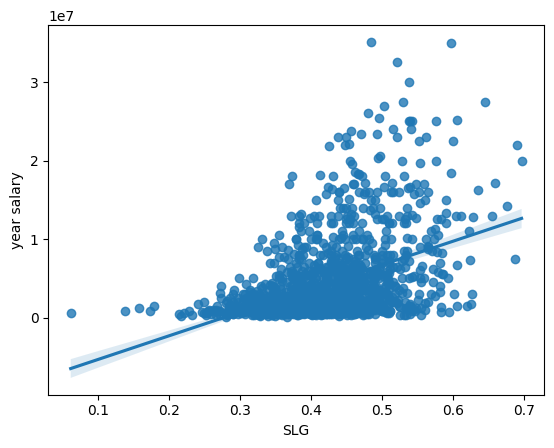

In [257]:
# Players yearly salary compared to their SLG
data = []
for index, contract in contracts.iterrows():
    if contract['playerName'] in list(batting['playerName']):
        year_salary = contract['yearSalary']
        stat = getBattingStat(batting_grouped, contract['playerName'], contract['year']-1, 'SLG')
        if stat > 0 and stat < 0.8:
            data.append((stat, year_salary))
fig, ax = plt.subplots()
sns.regplot(data=pd.DataFrame(data=data, columns = ['SLG', 'year salary']), x='SLG', y='year salary')